In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Cmu/h2p2/data/11-785-fall-20-homework-2-part-2.zip > /dev/null

In [ ]:
!nvidia-smi


Tue Mar  2 13:20:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Test with block.expansion = 1 and 4
With and without relu for last verf layer
biase = false and true

In [ ]:
import os
import numpy as np
from PIL import Image
import time

import torch
import torchvision   
import torch.nn as nn
import torch.nn.functional as F
import torch.tensor as Tensor
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda = torch.cuda.is_available()

In [ ]:
def conv3x3(in_channels, out_channels, stride = 1,padding = 1):
    """3x3 convolution with Padding"""
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,bias=False,padding = padding)


def conv1x1(in_channels, out_channels, stride = 1):
    """1x1 convolution"""
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

In [ ]:
#For Resnet 50( Imaprove on Performance BottleNeck Instead of Basic Residual)
class Bottleneck(nn.Module):
    expansion = 4#change to 4 later
    def __init__(self,inplanes,planes,norm_layer = None,stride = 1,downsample = None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = norm_layer(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = norm_layer(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self,in_channels, out_channels, norm_layer,stride = 1,downsample = None):
        super(BasicBlock,self).__init__()
        self.conv1 = conv3x3(in_channels,out_channels,stride)
        self.bn1 = norm_layer(out_channels)
        self.relu = nn.ReLU(inplace=True) # A small amout of memory compare to inplace = False(default)
                                          # Only if there is no Error
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = norm_layer(out_channels)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self,x):
        identity = x # For shortcut

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
          identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

In [ ]:
class ResNet(nn.Module):
  def __init__(self,block,layers,num_classes = 1000, zero_init_residual = False,feat_dim=100):
    super(ResNet, self).__init__()
    self._norm_layer = nn.BatchNorm2d
    self.inplanes = 64
    
    #From RGB(3_channels -> 64 Channels) Resnet Paper Arch
    #7x7 Conv, 64,/2
    self.conv1 = nn.Conv2d(3,self.inplanes,kernel_size=7,stride=2,padding=3
                           ,bias=False)# Bias False as Already in Batch
    self.bn1 = nn.BatchNorm2d(self.inplanes)
    self.relu = nn.ReLU(inplace=True)
    
    #pool, /2
    self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

    #Group of Residual Blocks
    self.layer1 = self._make_layer(block, 64, layers[0])
    self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
    self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
    self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

    #layer Befor fully connected(max pool)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    ##original 
    #self.fc = nn.Linear(512, num_classes)
    #self.linear_label = nn.Linear(512 * block.expansion, num_classes, bias=False)
    self.linear_label = nn.Linear(512 * block.expansion, num_classes)
    #For our problem 
    # For creating the embedding to be passed into the Center Loss criterion
    #self.linear_closs = nn.Linear(512, feat_dim, bias=False)
    self.linear_closs = nn.Linear(512*block.expansion, feat_dim)
    #self.relu_closs = nn.ReLU(inplace=True)  # Test with  relu and without
    #self.relu_closs = nn.LeakyReLU(inplace=True)  #Maybe only for classification use relu

    #Initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    
    # Zero-initialize the last BN in each residual branch,
    # so that the residual branch starts with zeros, and each residual block behaves like an identity.
    # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
    if zero_init_residual:
      for m in self.modules():
        if isinstance(m, BasicBlock):
          nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]
    
  def _make_layer(self, block, planes, blocks,stride=1):
    norm_layer = self._norm_layer
    downsample = None
    if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes*block.expansion, stride),
                norm_layer(planes*block.expansion),
            )
    layers = []
    layers.append(block(self.inplanes, planes, norm_layer,stride,downsample))
    self.inplanes = planes * block.expansion
    for _ in range(1, blocks):
      layers.append(block(self.inplanes, planes,norm_layer=norm_layer))
    return nn.Sequential(*layers)

  def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        #output = x.detach().clone()
        label_output = self.linear_label(x)
        #label_output = label_output/torch.norm(self.linear_label.weight, dim=1)

        # Create the feature embedding for the Center Loss
        class_output = self.linear_closs(x)
        #class_output = self.relu_closs(class_output)

        return class_output, label_output

  def forward(self, x):
        return self._forward_impl(x)
  

In [ ]:
def _resnet(block,layers,**kwargs):
    model = ResNet(block, layers,**kwargs)
    return model

def resnet18(**kwargs):
  return _resnet(BasicBlock,[2,2,2,2],**kwargs)

def resnet50(**kwargs):
    return _resnet(Bottleneck, [3, 4, 6, 3],**kwargs)

In [ ]:
class CenterLoss(nn.Module):
    """
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes, feat_dim, device=torch.device('cpu')):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.device = device
        
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).to(self.device))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long().to(self.device)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = []
        for i in range(batch_size):
            value = distmat[i][mask[i]]
            value = value.clamp(min=1e-12, max=1e+12) # for numerical stability
            dist.append(value)
        dist = torch.cat(dist)
        loss = dist.mean()

        return loss

In [ ]:
class RunningAverage():
    """A simple class that maintains the running average of a quantity
    
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """
    def __init__(self):
        self.steps = 0
        self.total = 0
    
    def update(self, val):
        self.total += val
        self.steps += 1
    
    def __call__(self):
        return self.total/float(self.steps)

In [ ]:
def one_epoch(epoch,net,loader,optimizer_label,optimizer_center,criterion_closs):
  net.train()
  running_loss = 0.0
  n = 0
  correct = 0
  total = 0
  loss_avg = RunningAverage()
  with tqdm(total=len(loader)) as t:
    for i,(inputs,labels) in enumerate(loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      #optimizer.zero_grad()
      optimizer_label.zero_grad()
      optimizer_center.zero_grad()

      
      feature_vec,outputs = net(inputs)

  
      label_loss = F.cross_entropy(outputs,labels)
      center_loss = criterion_closs(feature_vec,labels)
      loss = label_loss + hyper_param["closs_weight"] * center_loss


      running_loss += loss.item()
      loss.backward()
      optimizer_label.step()

      for param in criterion_closs.parameters():
        param.grad.data *= (1. / hyper_param["closs_weight"])
      optimizer_center.step()


      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      torch.cuda.empty_cache()
      start = time.time()
      '''
      if(i%100 == 99):
        print(f"**Done: Batch {i+1}")
        end = time.time()
        print(f"Time to do 100 batches :{end - start}")
      '''
      loss_avg.update(loss.item())
      del inputs
      del labels
      del loss
      t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
      t.update()

  avg_loss = running_loss / total
  acc = correct / total *100
  return avg_loss,acc

In [ ]:
def infer_classfication(net, loader,criterion_closs):
    net.eval()
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs,labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            # forward + backward + optimize
            feature_vec,outputs = net(inputs)
            #loss = F.cross_entropy(outputs, labels)
            label_loss = F.cross_entropy(outputs,labels)
            center_loss = criterion_closs(feature_vec,labels)
            loss = label_loss + hyper_param["closs_weight"] * center_loss

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del inputs
            del labels

    acc = correct / total * 100
    avg_loss = running_loss / total
    return avg_loss, acc

In [ ]:
def save_checkpoint(state, is_best, checkpoint):
    """Saves model and training parameters at checkpoint + 'last.pth.tar'. If is_best==True, also saves
    checkpoint + 'best.pth.tar'
    Args:
        state: (dict) contains model's state_dict, may contain other keys such as epoch, optimizer state_dict
        is_best: (bool) True if it is the best model seen till now
        checkpoint: (string) folder where parameters are to be saved
    """
    filepath = os.path.join(checkpoint, 'last.pth.tar')
    if not os.path.exists(checkpoint):
        print("Checkpoint Directory does not exist! Making directory {}".format(checkpoint))
        os.mkdir(checkpoint)
    else:
        print("Checkpoint Directory exists! ")
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'best.pth.tar'))


def load_checkpoint(checkpoint, model, optimizer1=None,optimizer2 = None,scheduler=None):
    """Loads model parameters (state_dict) from file_path. If optimizer is provided, loads state_dict of
    optimizer assuming it is present in checkpoint.
    Args:
        checkpoint: (string) filename which needs to be loaded
        model: (torch.nn.Module) model for which the parameters are loaded
        optimizer: (torch.optim) optional: resume optimizer from checkpoint
    """
    if not os.path.exists(checkpoint):
        raise("File doesn't exist {}".format(checkpoint))
    #checkpoint = torch.load(checkpoint)
    checkpoint = torch.load(checkpoint,map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer1 and optimizer2:
        optimizer1.load_state_dict(checkpoint['optimizer_Adam_state_dict'])
        optimizer2.load_state_dict(checkpoint['optimizer_closs_state_dict'])
    
    if scheduler:
      scheduler.load_state_dict(checkpoint["scheduler_save"])

    return checkpoint

In [ ]:
def train_step(net,loader,dev_loader,verf_loader,optimizer1,optimizer2,scheduler,criterion_closs,epochs,task='Classification'):
  net.train()
  train_losses = []
  valid_losses = []
  valid_acc = []
  auc_acc = []
  for epoch in range(epochs):
    for prarm_group in optimizer1.param_groups:
	        print("Current lr: \t{}".format(prarm_group["lr"]))
    avg_loss_t, acc_t = one_epoch(epoch, net, loader, optimizer1,optimizer2,criterion_closs)

    print(f'\n\n*************\n')
    print('Epoch [%d], loss: %.8f, acc: %.4f' %
                (epoch + 1, avg_loss_t, acc_t))
    if task == 'Classification':
      avg_loss_v, acc_v = infer_classfication(net, dev_loader,criterion_closs)
      valid_losses.append(avg_loss_v)
      valid_acc.append(acc_v)
      print('[Classification valid] loss: %.8f, acc: %.4f\n\n' % (avg_loss_v, acc_v))
    else:      
      pass
    #scheduler.step() # StepLR
    scheduler.step(avg_loss_v) # ReduceonPlateau
    train_losses.append(avg_loss_t)
    
    print('\n','='*20)
    print("*** Saving Checkpoint ***\n")
    #path = "{}Model_Epoch_{}_v1.txt".format(hyper['weightDirName'], str(epoch))
    save_checkpoint({'epoch': epoch + 1,
                               'model_state_dict': net.state_dict(),
                               'optimizer_Adam_state_dict': optimizer1.state_dict(),
                               'optimizer_closs_state_dict': optimizer2.state_dict(),
                              'scheduler_save' : scheduler.state_dict(),
                               'train_loss': train_losses,
                                'dev_loss':valid_losses,
                                'dev_acc': valid_acc,},
                              is_best=False,
                              checkpoint="gdrive/MyDrive/Cmu/h2p2/Checkpoint")
    '''
    path = "gdrive/MyDrive/Cmu/data_resnt/"+"Model_"+str(epoch) #colab
    torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_Adam_state_dict': optimizer1.state_dict(),
            'optimizer_closs_state_dict': optimizer2.state_dict(),
            'train_loss': train_losses,
            'dev_loss':valid_losses,
            'dev_acc': valid_acc,
            #'Auc_score' : auc_acc
        }, path)
    '''
  return train_losses, valid_losses,valid_acc

In [ ]:
def get_loader(train_dataset,dev_dataset,test_dataset,batch_size = 256):
  num_workers = 8
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               shuffle=True, num_workers=num_workers,pin_memory=True)

  
  dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, 
                                             shuffle=True, num_workers=num_workers, pin_memory=True)

  
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, 
                                             shuffle=False, num_workers=num_workers, pin_memory=True)
  
  return train_dataloader, dev_dataloader, test_dataloader

In [ ]:
def main():
  
  ''' 
  #lr = 1e-2
  lr = 0.01
  #weightDecay = 5e-5
  numEpochs = 5
  feat_dim = 100
  batch_size = 128
  #Centre Loss hyperpram
  closs_weight = 1
  lr_cent = 0.5
  ''' 
  #Dataset
  #data_path = 'gdrive/MyDrive/Cmu/h2p2/data/classification_data/'
  data_path = "classification_data/"
  transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

  train_dataset = torchvision.datasets.ImageFolder(root=data_path+'train_data/', 
                                                 transform = transform)
  dev_dataset = torchvision.datasets.ImageFolder(root=data_path+'val_data/', 
                                               #transform=torchvision.transforms.ToTensor())
                                               transform = transform)
  
  test_dataset = torchvision.datasets.ImageFolder(root=data_path+'test_data/', 
                                               #transform=torchvision.transforms.ToTensor())
                                               transform = transform)


  num_classes = len(train_dataset.classes)
  
  #Model based on Resnet50
  resnet50_model = resnet50(num_classes= num_classes,feat_dim =hyper_param["feat_dim"])
  resnet50_model.to(device)

  #Print
  print(resnet50_model)
  print(f'Train Images: {train_dataset.__len__()} \nDev Images : {dev_dataset.__len__()} \nTest Images : {test_dataset.__len__()}')
  print('Batch Size: ',hyper_param["batch_size"])
  print("#Lables for N-way clasf:",num_classes)
  print("Image Size: 224")
  print("Size of face embedding: ",hyper_param["feat_dim"])


  #Loss, Optimizer, and scheduler
  criterion_closs = CenterLoss(num_classes, hyper_param["feat_dim"], device)
  #Adam_optimizer = torch.optim.Adam(resnet50_model.parameters(),lr = lr,weight_decay=weightDecay)
  Adam_optimizer = torch.optim.Adam(resnet50_model.parameters(),lr = hyper_param["lr"])
  optimizer_closs = torch.optim.SGD(criterion_closs.parameters(), lr=hyper_param["lr_cent"])
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(Adam_optimizer,mode='min',patience=1)
  
  print("-------------> Loading saved model<---------------")
  hyper_param["infer"] = load_checkpoint(hyper_param["checkpoint"],resnet50_model,Adam_optimizer,optimizer_closs)
  train_loss,dev_loss,d_acc = hyper_param["infer"]["train_loss"][-1],hyper_param["infer"]["dev_loss"][-1], hyper_param["infer"]["dev_acc"][-1]
  print(f"[Prev Model's] \nTrain loss:{train_loss}  \nDev Loss: {dev_loss} \tDev Accuracy: {d_acc}")
  hyper_param["loaded_model"] = resnet50_model
  
  print("Started Loading")
  start = time.time()
  train_dataloader, dev_dataloader, test_dataloader = get_loader(train_dataset,dev_dataset,test_dataset,hyper_param["batch_size"])
  end = time.time()
  print("Finished Loading")
  print(f"Time to get Loader :{end - start}")
  verification_loader = None
  print("$$$  =============>Strated  Training $$$")
  train_losses, valid_losses, valid_acc = train_step(resnet50_model, train_dataloader, dev_dataloader, verification_loader,Adam_optimizer,optimizer_closs,scheduler,criterion_closs,hyper_param["numEpochs"])

In [ ]:
!nvidia-smi

Tue Mar  2 13:20:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
'''
if __name__ == "__main__":
  hyper_param = {
    "lr": 1e-2,
    "batch_size": 128,
    "numEpochs": 10, 
    "num_workers": 8,
    "closs_weight" : 1,
    "lr_cent" : 0.5,
    "feat_dim" : 100,
    "closs_weight" : 1,
    "checkpoint":"gdrive/MyDrive/Cmu/h2p2/Checkpoint/last.pth.tar",
    "infer" : None,
    "loaded_model" : None
  }
  main()
  '''

'\nif __name__ == "__main__":\n  hyper_param = {\n    "lr": 1e-2,\n    "batch_size": 128,\n    "numEpochs": 10, \n    "num_workers": 8,\n    "closs_weight" : 1,\n    "lr_cent" : 0.5,\n    "feat_dim" : 100,\n    "closs_weight" : 1,\n    "checkpoint":"gdrive/MyDrive/Cmu/h2p2/Checkpoint/last.pth.tar",\n    "infer" : None,\n    "loaded_model" : None\n  }\n  main()\n  '

In [ ]:
!nvidia-smi

Tue Mar  2 13:20:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Inference**

In [ ]:
print(device)

cuda


In [ ]:
resnet50_model = resnet50(num_classes= 4000,feat_dim =100)
resnet50_model.to(device)
checkpoint_infer = load_checkpoint("gdrive/MyDrive/Cmu/h2p2/Checkpoint/last.pth.tar",resnet50_model,None,None)

In [ ]:
def plot_loss_acc(name,score):
    """
    Plots the loss or Acc against epochs
    
    Args:
        name: (string) Either Train loss, Dev Loss or Dev Accuracy
        score: (list) list of loss/accuray with epochs
    """
    plt.title(name)
    plt.xlabel('Epoch Number')
    plt.ylabel(name.split(sep=' ')[1])
    plt.plot(score)
    #plt.savefig("graphs/"+name+".png")
    plt.show()


In [ ]:
def lerning_curve(train_loss, dev_loss):
  plt.figure(figsize=(10, 6))
  plt.plot( train_loss,"r-+", linewidth=3, label="Training loss")
  plt.plot(dev_loss, "b-", linewidth=2, label="Dev loss")
  plt.legend(loc="best", fontsize=14)   
  plt.xlabel("Epochs", fontsize=14) 
  plt.ylabel("Loss", fontsize=14) 
  plt.title("Learning Curve")
  #plt.savefig("graphs/"+name+".png")
  plt.show()

In [ ]:
train_loss,dev_loss,d_acc = checkpoint_infer["train_loss"],checkpoint_infer["dev_loss"], checkpoint_infer["dev_acc"]

In [ ]:
#lerning_curve(train_loss, dev_loss)


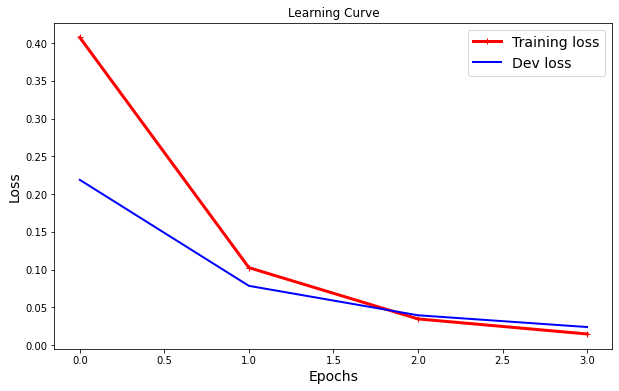

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot( train_loss,"r-+", linewidth=3, label="Training loss")
plt.plot(dev_loss, "b-", linewidth=2, label="Dev loss")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Epochs", fontsize=14) 
plt.ylabel("Loss", fontsize=14) 
plt.title("Learning Curve")
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
num_workers = 0 if device == "cpu" else 8
pin_memory= false if device == "cpu" else True

test_dataset = torchvision.datasets.ImageFolder(root="classification_data/test_data/", 
                                               #transform=torchvision.transforms.ToTensor())
                                               transform = transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, 
                                             shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [ ]:
hyper_param = {
    "lr": 1e-2,
    "batch_size": 128,
    "numEpochs": 10, 
    "num_workers": 8,
    "closs_weight" : 1,
    "lr_cent" : 0.5,
    "feat_dim" : 100,
    "closs_weight" : 1,
    "checkpoint":"gdrive/MyDrive/Cmu/h2p2/Checkpoint/last.pth.tar",
    "infer" : None,
    "loaded_model" : None
  }
criterion_closs = CenterLoss(4000, 100, device)
avg_loss_test, acc_test = infer_classfication(resnet50_model,test_dataloader,criterion_closs)
print(f"*** Classifier <-> Feature Extractor\n [Test] Loss:{avg_loss_test} \t Accuracy:{acc_test} ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


*** Classifier <-> Feature Extractor
 [Test] Loss:1.0179585103988646 	 Accuracy:68.0375 


In [ ]:
class MyDatasetVerify(Dataset):
    # Create dataset for validation of verification tast
    def __init__(self, pairFN, imgFolderPath):
        self.imgFolderPath = imgFolderPath
        with open(pairFN) as f:
            self.pairList = [line.rstrip() for line in f]
    def __len__(self):
        return len(self.pairList)
    def __getitem__(self, idx):
        transform = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

        items = self.pairList[idx].split()
        fn1, fn2 = items[0], items[1]
        img1 = Image.open(self.imgFolderPath + fn1)
        img2 = Image.open(self.imgFolderPath + fn2)
        img1 = transform(img1)
        img2 = transform(img2)
        #img1 = transforms.ToTensor()(img1)
        #img2 = transforms.ToTensor()(img2)
        if len(items) == 3: # validation
            return img1, img2, int(items[2])
        else: # test
            return img1, img2, -1
    def getPairList(self):
        return self.pairList


def testVerify(model, vLoader):
    model.eval()
    similarity = np.array([])
    true = np.array([])
    with torch.no_grad():
        for batch_idx, (imgs1, imgs2, targets) in enumerate(vLoader):
            imgs1, imgs2, targets = imgs1.float().to(device), imgs2.float().to(device), targets.float().to(device)
            # find cos similarity between embeddings
            facImbd_img1 = model(imgs1.float())[0]
            facImbd_img2 = model(imgs2.float())[0]
            sim = F.cosine_similarity(facImbd_img1, facImbd_img2) 
            similarity = np.concatenate((similarity, sim.cpu().numpy().reshape(-1)))
            true = np.concatenate((true, targets.cpu().numpy().reshape(-1)))
            del imgs1
            del imgs2
            del targets
    return similarity, true

def get_roc_curve(true_score,predict_score):
    fpr, tpr, thresholds = roc_curve(true_score, predict_score)
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(10, 6))
    plot_roc_curve(fpr, tpr)
    plt.show()
    #plt.savefig('graphs/roc.png')


def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, color='darkorange', linewidth=8, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve (Train Data)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [ ]:

testVeriLabelName = "/content/gdrive/MyDrive/Cmu/h2p2/output/test_veri_labels.npy"
testVeriLabelCSVfn = "/content/gdrive/MyDrive/Cmu/h2p2/output/test_veri_labels.csv"
#Verification Validation
vrf_val_dataset = MyDatasetVerify('verification_pairs_val.txt',"")

verf_val_loader = torch.utils.data.DataLoader(vrf_val_dataset, batch_size=200, 
                                             shuffle=False, num_workers = 1)

In [ ]:
#for param in resnet50_model.parameters():
#  print(param.data)

In [ ]:

	# Calculate simliarity score
cosSim_valid, trueScore_valid = testVerify(resnet50_model, verf_val_loader)
    # Report AUC
#get_roc_curve(trueScore_valid,cosSim_valid)
auc = roc_auc_score(trueScore_valid, cosSim_valid)
print("*** AUC: {} ***".format(auc))

*** AUC: 0.8824221199678957 ***


In [ ]:
import pandas as pd
#Verification for test
vrf_test_dataset = MyDatasetVerify('verification_pairs_test.txt',"")

verf_test_loader = torch.utils.data.DataLoader(vrf_test_dataset, batch_size=300, 
                                             shuffle=False, num_workers = 8)
    
cosSim_test, _ = testVerify(resnet50_model, verf_test_loader)

	# Save predictied similarity
cosSim_test = np.array(cosSim_test)
np.save(testVeriLabelName, cosSim_test)
trial = np.array(vrf_test_dataset.getPairList())
df = pd.DataFrame({"trial" : trial, "score" : cosSim_test})
df.to_csv(testVeriLabelCSVfn, index=False)

In [ ]:
'''data_iter = iter(verf_test_loader)
images1,images2,labels = data_iter.next()'''

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


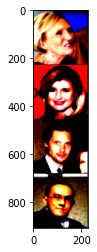

In [ ]:
#im = torchvision.utils.make_grid(images1[:4],nrow=1)
#plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([-1, -1, -1, -1])


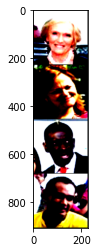

In [ ]:
'''
im = torchvision.utils.make_grid(images2[:4],nrow=1)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
print(f"Labels: {labels[:4]}")'''

In [ ]:
df.head(10)


,trial,score
0,verification_data/00020839.jpg verification_da...,0.735332
1,verification_data/00002921.jpg verification_da...,0.488608
2,verification_data/00011732.jpg verification_da...,0.340157
3,verification_data/00052778.jpg verification_da...,0.147349
4,verification_data/00053948.jpg verification_da...,0.563070
5,verification_data/00011732.jpg verification_da...,0.639023
6,verification_data/00046783.jpg verification_da...,-0.028300
7,verification_data/00002921.jpg verification_da...,0.044919
8,verification_data/00002921.jpg verification_da...,0.136344
9,verification_data/00066200.jpg verification_da...,0.644636


In [ ]:
def testVerify(model, vLoader):
    model.eval()
    similarity = np.array([])
    true = np.array([])
    with torch.no_grad():
        for batch_idx, (imgs1, imgs2, targets) in enumerate(vLoader):
            imgs1, imgs2, targets = imgs1.float().to(device), imgs2.float().to(device), targets.float().to(device)
            # find cos similarity between embeddings
            facImbd_img1 = model(imgs1.float())[0]
            facImbd_img2 = model(imgs2.float())[0]
            sim = F.cosine_similarity(facImbd_img1, facImbd_img2) 
            similarity = np.concatenate((similarity, sim.cpu().numpy().reshape(-1)))
            true = np.concatenate((true, targets.cpu().numpy().reshape(-1)))
            del imgs1
            del imgs2
            del targets
    return similarity, true

In [ ]:
data_iter = iter(verf_test_loader)
images1,images2,labels = data_iter.next()

In [ ]:
images11, images12 = images1[0], images1[1]
images21, images22 = images2[0] , images2[1]
labels1, labels2 = labels[0], labels[1]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


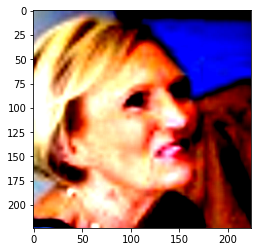

In [ ]:
plt.imshow(np.transpose(images11.numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


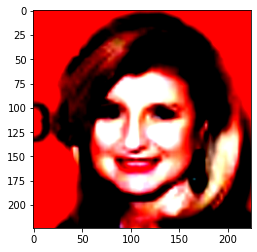

In [ ]:
plt.imshow(np.transpose(images12.numpy(), (1, 2, 0)))

In [ ]:
images11[None,:].shape

torch.Size([1, 3, 224, 224])

In [ ]:
resnet50_model.eval()
with torch.no_grad():
  imgs1, imgs2, labels1,labels2 = images11[None,:].float().to(device), images12[None,:].float().to(device), labels1.float().to(device),labels2.float().to(device)
  facImbd_img1 = resnet50_model(imgs1.float())[0]
  facImbd_img2 = resnet50_model(imgs2.float())[0]
  print(facImbd_img1[:10])
  print(facImbd_img2[:10])


tensor([[-0.0512, -0.0772, -0.0593, -0.0515, -0.0559, -0.0617, -0.0561, -0.0521,
         -0.0451, -0.0481, -0.0633, -0.0515, -0.0713, -0.0527, -0.0577, -0.0525,
         -0.0396, -0.0519, -0.0440, -0.0689, -0.0438, -0.0991, -0.0494, -0.0418,
         -0.0518, -0.0486, -0.0634, -0.0885, -0.0423, -0.0675, -0.0667, -0.0511,
         -0.0934, -0.0656, -0.0439, -0.0480, -0.0520, -0.0546, -0.0967, -0.0664,
         -0.0499, -0.0508, -0.0461, -0.0532, -0.0543, -0.0459, -0.0390, -0.0870,
         -0.0612, -0.0514, -0.0472, -0.0465, -0.0555, -0.0577, -0.0367, -0.0615,
         -0.0593, -0.0592, -0.0564, -0.0520, -0.0751, -0.0415, -0.1057, -0.0582,
         -0.0438, -0.0641, -0.0708, -0.0459, -0.0547, -0.0545, -0.0327, -0.0396,
         -0.0518, -0.0566, -0.0553, -0.0444, -0.0749, -0.0730, -0.0626, -0.0473,
         -0.0517, -0.0468, -0.0631, -0.0346, -0.0651, -0.0476, -0.0490, -0.0523,
         -0.0310, -0.0500, -0.0641, -0.0471, -0.0722, -0.0417, -0.0598, -0.0528,
         -0.0732, -0.0525, -

In [ ]:
def verf_two_img(img1,img2,model):
  
  model.eval()

  with torch.no_grad():
    imgs1, imgs2 = imgs1.float().to(device), imgs2.float().to(device)
            # find cos similarity between embeddings
    facImbd_img1 = model(imgs1.float())[0]
    facImbd_img2 = model(imgs2.float())[0]
    sim = F.cosine_similarity(facImbd_img1, facImbd_img2) 
    result = "Match" if sim > 0.3 else "Not a Match"
  return result


In [ ]:
resnet50_model = resnet50(num_classes= 4000,feat_dim =100)
resnet50_model.to(device)
transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
images11, images12 = transform(img1), transform(img2)
verf_two_img(images11,images12,resnet50_model)

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


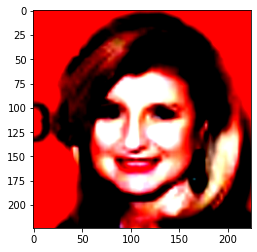

In [ ]:
plt.imshow(np.transpose(images12.numpy(), (1, 2, 0)))

In [ ]:
resnet50_model = resnet50(num_classes= 4000,feat_dim =100)
resnet50_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 